In [1]:
import os
os.getcwd()
os.chdir('C:/Users/bhaku/Desktop/fake reviews')
os.getcwd()
import warnings
warnings.filterwarnings('ignore')

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, recall_score,precision_score, make_scorer,fbeta_score
from sklearn import svm, tree
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, ShuffleSplit, train_test_split
from wordcloud import WordCloud
from collections import Counter
from itertools import combinations
from gensim import models,corpora,similarities
from nltk.util import ngrams
import string
import matplotlib.pyplot as plt
import re
import nltk


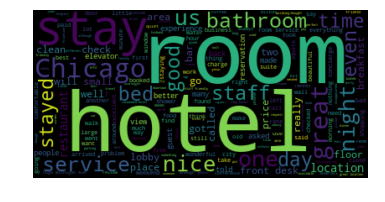

In [3]:

reviews = pd.read_csv('deceptive-opinion.csv')
reviews_txt =  reviews['text']
    
labels = reviews['deceptive'].values
labels = (labels == 'truthful') * 1
labels = pd.Series(labels)
    
truthful_indices = labels[labels == 1].index.values
deceptive_indices = labels[labels == 0].index.values

truthful_txt = ' '.join(reviews_txt[truthful_indices].values).replace("\n"," ")
deceptive_txt = ' '.join(reviews_txt[deceptive_indices].values).replace("\n"," ")

num_docs = reviews_txt.shape[0]



wordcloud = WordCloud().generate(truthful_txt)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

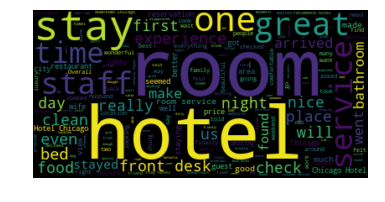

In [4]:
wordcloud = WordCloud().generate(deceptive_txt)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


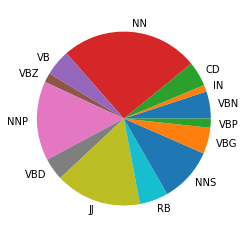

In [5]:
tokens = nltk.word_tokenize(truthful_txt)
tagged_tokens = nltk.pos_tag(tokens)

tags = Counter(dict(tagged_tokens).values()).keys()
freqs = Counter(dict(tagged_tokens).values()).values()
    
inds=np.where(np.array(list(freqs)) > 50)[0]
tags=np.array(list(tags))[inds]
freqs=np.array(list(freqs))[inds]

plt.pie(freqs, labels=tags)
plt.show()


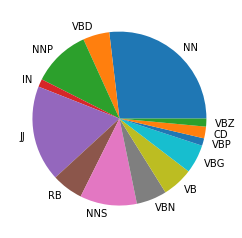

In [6]:
tokens = nltk.word_tokenize(deceptive_txt)
tagged_tokens = nltk.pos_tag(tokens)

tags = Counter(dict(tagged_tokens).values()).keys()
freqs = Counter(dict(tagged_tokens).values()).values()
    
inds=np.where(np.array(list(freqs)) > 50)[0]
tags=np.array(list(tags))[inds]
freqs=np.array(list(freqs))[inds]

plt.pie(freqs, labels=tags)
plt.show()


In [7]:
# first remove common words (pronouns etc) which are not informative in themselves

txt_removed = [None] * num_docs
freq = 50
num_bins = 50
for i in range(0,num_docs):
        
    common_words = 'a at for of the and to in & $'.split()
    
    words = reviews_txt[i].lower().split()
        
    txt_removed[i] = ' '.join([word for word in words if word not in common_words])
    
#to compute mutual information we need several components...
    
    
bins = np.zeros([num_docs,2])
  
p_c1 = float(len(truthful_indices)) / num_docs # the unconditional probability of getting a truthful review
    
p_c2 = float(len(deceptive_indices)) / num_docs # same but for deceptive reviews
    
p_c = np.array([[p_c1],[p_c2]])
    
type_entropy = -np.sum(p_c * np.log(p_c)) #unconditional entropy
    
ngram_counts = CountVectorizer(analyzer='word', ngram_range=(1, 1), min_df=1) # let's count all the words in the corpus
word_counts = ngram_counts.fit_transform(txt_removed)

num_words = len(ngram_counts.vocabulary_.values())

word_vocab = [None] * num_words

for n in range(0,num_words-1):
        
    index = np.array(list(ngram_counts.vocabulary_.values()))[n]
        
    word_vocab[index] = np.array(list(ngram_counts.vocabulary_.keys()))[n]
           
    
subset_indices = (np.where(np.sum(word_counts.toarray(),axis=0)>freq))[0]
    
word_vocab_subset = [word_vocab[i] for i in subset_indices]

word_counts_subset = word_counts[:,subset_indices]
    
num_words_subset = np.shape(word_counts_subset)[1]
    
info_gain = np.zeros(num_words_subset)
    
bins = range(0,num_bins)
    
for n in range(0,num_words_subset):
            
    p_wc = np.zeros((2,len(bins)-1)) # word likelihood given a category
        
    b, bin_edges = np.histogram(word_counts_subset[truthful_indices,n].toarray(),bins=bins)
        
    p_wc[0,:] = b.astype('float') / len(truthful_indices)
        
    b, bin_edges = np.histogram(word_counts_subset[deceptive_indices,n].toarray(),bins=bins)
        
    p_wc[1,:] = b.astype('float') / len(deceptive_indices)
        
    b, bin_edges = np.histogram(word_counts_subset[:,n].toarray(),bins=bins)
        
    p_w = b.astype('float') / num_docs
        
    p_cw = np.multiply(p_wc,p_c) / p_w # we finally get to calculate conditional probability of a category given a word
        
    conditional_entropy = -np.nansum((p_w * p_cw) * np.log(p_cw))
        
    info_gain[n] = ((type_entropy - conditional_entropy) / type_entropy) * 100
        
    names = np.array(word_vocab_subset)    
        
    info_per_word = dict(zip(names,info_gain)) # and now we have mutual info

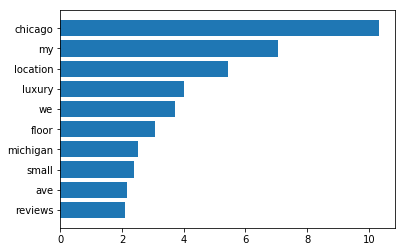

In [8]:
# plotting 

ranked_words = np.array(list(info_per_word.keys()))[np.argsort(list(info_per_word.values()))]
ranked_vals = np.array(list(info_per_word.values()))[np.argsort(list(info_per_word.values()))]

ranked_words_top10 = ranked_words[len(info_per_word)-10:len(info_per_word)]
ranked_vals_top10 = ranked_vals[len(info_per_word)-10:len(info_per_word)]

fig, ax = plt.subplots()
  
ax.barh(np.arange(10),np.array(ranked_vals_top10))
plt.rcdefaults()

ax.set_yticks(np.arange(10))
ax.set_yticklabels(ranked_words_top10)
plt.show()

In [9]:
#it has been prooven historically that bigrams works better
bigrams_docs = [None] * num_docs
    
acceptable_tags = ['CC','CD','DT','IN','EX','LS','MD','POS','PDT','RP','TO','WDT','WP','WRB','PRP$','PRP']               
    
tag_combos = [item for n,item in enumerate(combinations(acceptable_tags[::-1],2))] + [item for n,item in enumerate(combinations(acceptable_tags,2))]
translator = str.maketrans(dict.fromkeys(string.punctuation))

for i in range(0,num_docs):
        
    text=reviews_txt[i].lower().translate(translator)
        
    token = nltk.word_tokenize(text)
        
    bigrams = ngrams(token,2)
        
    valid_bigrams = [bigram for bigram in bigrams if tuple(dict(nltk.pos_tag(bigram)).values()) not in tag_combos]
    
    bigrams_docs[i] = ['_'.join(valid_bigrams[n]) for n,item in enumerate(valid_bigrams)]
    




['just_got', 'got_back', 'back_from', '2_days', 'days_up', 'up_in', 'in_chicago', 'chicago_shopping', 'shopping_with', 'with_girlfriends', 'girlfriends_first', 'first_time', 'time_i', 'i_have', 'have_stayed', 'stayed_at', 'the_omni', 'omni_i', 'i_did', 'did_so', 'so_because', 'because_i', 'i_saw', 'saw_a', '12900_rate', 'rate_that', 'that_included', 'included_2500', 'of_free', 'free_food', 'food_on', 'on_travelzoo', '55_year', 'year_olds', 'olds_all', 'all_stayed', 'stayed_in', 'one_suite', 'suite_with', '2_double', 'double_beds', 'beds_and', 'a_very', 'very_comfortable', 'comfortable_pull', 'pull_out', 'out_sofa', 'sofa_we', 'we_had', 'had_plenty', 'plenty_of', 'of_room', 'room_food', 'food_in', 'the_restaurant', 'restaurant_was', 'was_great', 'great_service', 'service_was', 'was_outstanding', 'outstanding_from', 'from_everone', 'everone_we', 'we_came', 'came_into', 'into_contact', 'contact_with', 'with_early', 'early_morning', 'morning_delivery', 'delivery_of', 'of_free', 'free_coffe

In [12]:
print(bigrams_docs[1])

['triple_a', 'a_rate', 'rate_with', 'with_upgrade', 'upgrade_to', 'to_view', 'view_room', 'room_was', 'was_less', 'less_than', 'which_also', 'also_included', 'included_breakfast', 'breakfast_vouchers', 'vouchers_had', 'had_a', 'a_great', 'great_view', 'view_of', 'of_river', 'river_lake', 'lake_wrigley', 'wrigley_bldg', 'bldg_tribune', 'tribune_bldg', 'bldg_most', 'most_major', 'major_restaurants', 'restaurants_shopping', 'shopping_sightseeing', 'sightseeing_attractions', 'attractions_within', 'within_walking', 'walking_distance', 'distance_large', 'large_room', 'room_with', 'a_very', 'very_comfortable', 'comfortable_bed']


In [13]:
dictionary=corpora.Dictionary(bigrams_docs)

corpus = [dictionary.doc2bow(text) for text in bigrams_docs]



num_topics = 100
chunksize = 400
passes = 5

model = models.LdaModel(corpus, id2word=dictionary, num_topics=num_topics,alpha = 'auto',eta='auto',random_state=0, chunksize=chunksize, passes=passes)

topic_dists = np.zeros([num_docs,num_topics])
    
for i,item in enumerate(corpus):
        
    dists = model.get_document_topics(item)
        
    indices = list(dict(dists).keys())
        
    vals = list(dict(dists).values())
        
    topic_dists[i,indices] = vals
    

In [14]:
clf = svm.SVC(random_state=0)

X_train, X_test, y_train, y_test = train_test_split(topic_dists, labels, test_size = 0.2, random_state = 0)
scorer = make_scorer(fbeta_score,beta=0.5)

parameters = {"kernel": ['rbf','linear'], "C": [0.1,0.2,0.4,0.6,0.8,1,10], "gamma": np.logspace(-1,1,9)} 
cv_sets = KFold(n_splits = 5, shuffle = True, random_state = 0)

grid_obj = GridSearchCV(clf, parameters,cv=cv_sets,scoring=scorer)
    
grid_fit = grid_obj.fit(X_train,y_train)
        
best_clf = grid_fit.best_estimator_

print(best_clf)

best_predictions = best_clf.predict(X_test)

performance = {'accuracy': accuracy_score(best_predictions,y_test),
                'recall': recall_score(best_predictions,y_test),
                'precision': precision_score(best_predictions,y_test)
                }

print(performance)


SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=5.623413251903491,
  kernel='rbf', max_iter=-1, probability=False, random_state=0,
  shrinking=True, tol=0.001, verbose=False)
{'accuracy': 0.7, 'recall': 0.8641975308641975, 'precision': 0.45161290322580644}
